<a href="https://colab.research.google.com/github/hchaparov/Dynamic_Pricing_MARL/blob/main/Final_2A_Connect4_ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install stable-baselines3
!pip install 'kaggle-environments'

In [ ]:
import gymnasium as gym
import os
import sys
import inspect
import numpy as np

import torch as th
import torch.nn as nn
th.set_printoptions(profile="full")

from tqdm.auto import tqdm
from stable_baselines3 import PPO
from stable_baselines3 import A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.monitor import Monitor, load_results
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from kaggle_environments import evaluate, make, utils

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
LOG_DIR_PPO = "/content/drive/MyDrive/connect4_test/logs_150k_ppo/"
os.makedirs(LOG_DIR_PPO, exist_ok=True)

LOG_DIR_A2C = "/content/drive/MyDrive/connect4_test/logs_150k_a2c/"
os.makedirs(LOG_DIR_A2C, exist_ok=True)

LOG_DIR_DQN = "/content/drive/MyDrive/connect4_test/logs_150k_dqn/"
os.makedirs(LOG_DIR_DQN, exist_ok=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class Connect4(gym.Env):

    def __init__(self, opponent = 'random', switch_prob = 0.5):
        self.env = make('connectx', debug = False)
        self.switch_prob = switch_prob
        self.agents = [None, opponent] # The agent will train in place of None
        self.trainer = self.env.train(self.agents)
        config = self.env.configuration
        # PyTorch Conv2d expect 4 dimensional data
        # (nSamples x nChannels x Height x Width)
        self.board_template = (1, config.rows, config.columns)
        self.board = np.zeros(self.board_template, int)

        # Define required gym fields
        self.reward_range = (-1, 0, 1) # lose: -1, draw: 0, win: 1
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Box(
            # ``low`` and ``high`` represent the possible values
            low = 0,
            high = 2,
            shape = self.board_template,
            dtype = int
        )

    def switch_starting_positions(self):
        self.agents = self.agents[::-1]
        self.trainer = self.env.train(self.agents)

    def step(self, action):
        # Check for invalid moves
        if self.board[0][0][int(action)] != 0:
            reward, done, info = -10, True, {}
            observation = self.board
        else:
            observation, reward, done, info = self.trainer.step(int(action))
            self.board = np.array(observation['board']).reshape(self.board_template)

        terminated = done
        truncated = False  # Truncation condition is not specified

        return self.board, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)

        if np.random.random() < self.switch_prob:
            self.switch_starting_positions()

        self.board = np.array(
            self.trainer.reset()['board']
        ).reshape(self.board_template)

        # Return the observation and an empty info dictionary
        return self.board, {}


training_env = Connect4('random')

# Add logging
training_env_ppo = Monitor(training_env, LOG_DIR_PPO, allow_early_resets = True)
training_env_a2c = Monitor(training_env, LOG_DIR_A2C, allow_early_resets = True)
training_env_dqn = Monitor(training_env, LOG_DIR_DQN, allow_early_resets = True)

# Vectorize environment (expected by stable-baselines3 algorithms)
training_env_ppo = DummyVecEnv([lambda: training_env_ppo])
training_env_a2c = DummyVecEnv([lambda: training_env_a2c])
training_env_dqn = DummyVecEnv([lambda: training_env_dqn])

In [ ]:
MODEL_PATH_PPO = '/content/drive/MyDrive/connect4_test/ppo_model_150k_new'
MODEL_PATH_A2C = '/content/drive/MyDrive/connect4_test/a2c_model_150k'
MODEL_PATH_DQN = '/content/drive/MyDrive/connect4_test/dqn_model_150k'



# Load or initialize agent
if os.path.exists(MODEL_PATH_PPO + '.zip'):
    print('Loading existing model\n')
    agent_ppo = PPO.load(
        path = MODEL_PATH_PPO,
        env = training_env_ppo,
        verbose = 1
    )
else:
    print('Creating a new model\n')
    agent_ppo = PPO(
        policy = 'MlpPolicy',
        env = training_env_ppo,
        learning_rate=3e-4,  # Lower learning rate for stable training
        n_steps=2048,        # Increase number of steps per update
        batch_size=64,       # Batch size for each update
        n_epochs=10,         # Number of epochs to optimize the surrogate loss
        gamma=0.99,          # Discount factor
        gae_lambda=0.95,     # Factor for trade-off of bias vs variance for Generalized Advantage Estimator
        clip_range=0.2,      # Clipping parameter
        ent_coef=0.01,       # Coefficient for entropy
        vf_coef=0.5,         # Coefficient for value function loss
        max_grad_norm=0.5,   # Maximum norm for gradient clipping
        verbose=1
    )




# Load or initialize A2C agent
if os.path.exists(MODEL_PATH_A2C + '.zip'):
    print('Loading existing A2C model\n')
    agent_a2c = A2C.load(
        path=MODEL_PATH_A2C,
        env=training_env_a2c,
        verbose=1
    )
else:
    print('Creating a new A2C model\n')
    agent_a2c = A2C(
        policy='MlpPolicy',
        env=training_env_a2c,
        learning_rate=0.001,    ###
        n_steps=5,
        gamma=0.99,
        gae_lambda=1.0,
        vf_coef=0.25,
        ent_coef=0.00001,   ###
        max_grad_norm=0.5,
        verbose=1
    )



# Load or initialize DQN agent
if os.path.exists(MODEL_PATH_DQN + '.zip'):
    print('Loading existing DQN model\n')
    agent_dqn = DQN.load(
        path=MODEL_PATH_DQN,
        env=training_env_dqn,
        verbose=1
    )
else:
    print('Creating a new DQN model\n')
    agent_dqn = DQN(
        policy='MlpPolicy',
        env=training_env_dqn,
        learning_rate=0.001,    #### Typical value for DQN
        buffer_size=50000,    # Size of the replay buffer
        learning_starts=1000, # Number of steps before learning starts
        batch_size=32,        # Batch size for each update
        gamma=0.95,      ###
        train_freq=(4, 'step'),  # Update every 4 steps
        target_update_interval=1000, # Target network update frequency
        exploration_fraction=0.1,    # Fraction of entire training period over which the exploration rate is reduced
        exploration_final_eps=0.02,  # Final value of random action probability
        max_grad_norm=10,          # Maximum norm for gradient clipping
        verbose=1
    )

Creating a new model

Using cuda device
Creating a new A2C model

Using cuda device
Creating a new DQN model

Using cuda device


In [ ]:
TOTAL_TIMESTEPS = 150_000
EVAL_FREQ = 4096 # The policy is updated every 2048 timesteps
EVAL_EPISODES = 100 # How many episodes the agent should be tested for evaluation


agent_ppo.learn(
        total_timesteps = TOTAL_TIMESTEPS,
        callback = [
            EvalCallback(
                eval_env = training_env_ppo,
                n_eval_episodes = EVAL_EPISODES,
                best_model_save_path = LOG_DIR_PPO,
                log_path = LOG_DIR_PPO,
                eval_freq = EVAL_FREQ,
                deterministic = True,
                render = False
            )
        ]
    )
agent_ppo.save(MODEL_PATH_PPO)


agent_a2c.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[
        EvalCallback(
            eval_env=training_env_a2c,
            n_eval_episodes=EVAL_EPISODES,
            best_model_save_path=LOG_DIR_A2C,
            log_path=LOG_DIR_A2C,
            eval_freq=EVAL_FREQ,
            deterministic=True,
            render=False
        )
    ]
)
agent_a2c.save(MODEL_PATH_A2C)



agent_dqn.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=[
        EvalCallback(
            eval_env=training_env_dqn,
            n_eval_episodes=EVAL_EPISODES,
            best_model_save_path=LOG_DIR_DQN,
            log_path=LOG_DIR_DQN,
            eval_freq=EVAL_FREQ,
            deterministic=True,
            render=False
        )
    ]
)
agent_dqn.save(MODEL_PATH_DQN)

Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0983   |
|    n_updates        | 34826    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.31     |
|    ep_rew_mean      | 0.41     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 19072    |
|    fps              | 100      |
|    time_elapsed     | 1390     |
|    total_timesteps  | 140335   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0879   |
|    n_updates        | 34833    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.32     |
|    ep_rew_mean      | 0.43     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 19076    |
|   

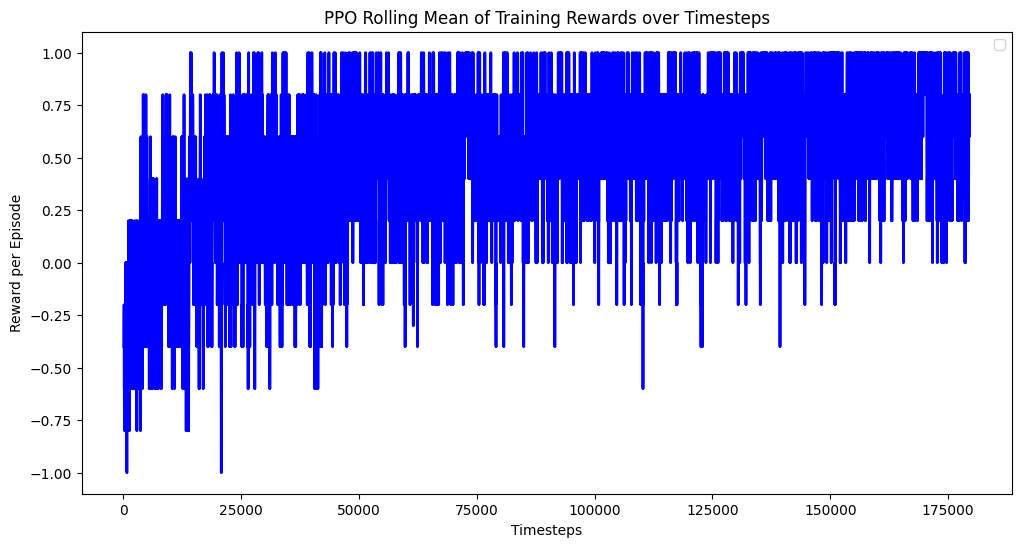

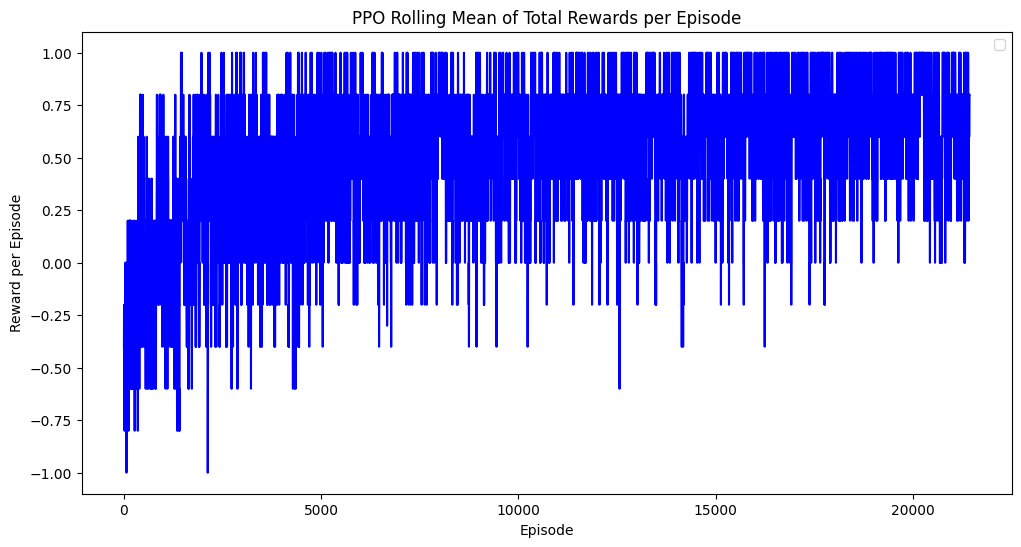

In [32]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_PPO)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})


# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards'] = results_df['rewards'].rolling(window=10).mean()

# Plot only the rolling mean for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards'], color='blue', linewidth=2)
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('PPO Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_PPO)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r'] = results['r'].rolling(window=10).mean()

# Plot rewards over episode index with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r'], color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('PPO Rolling Mean of Total Rewards per Episode')
plt.show()

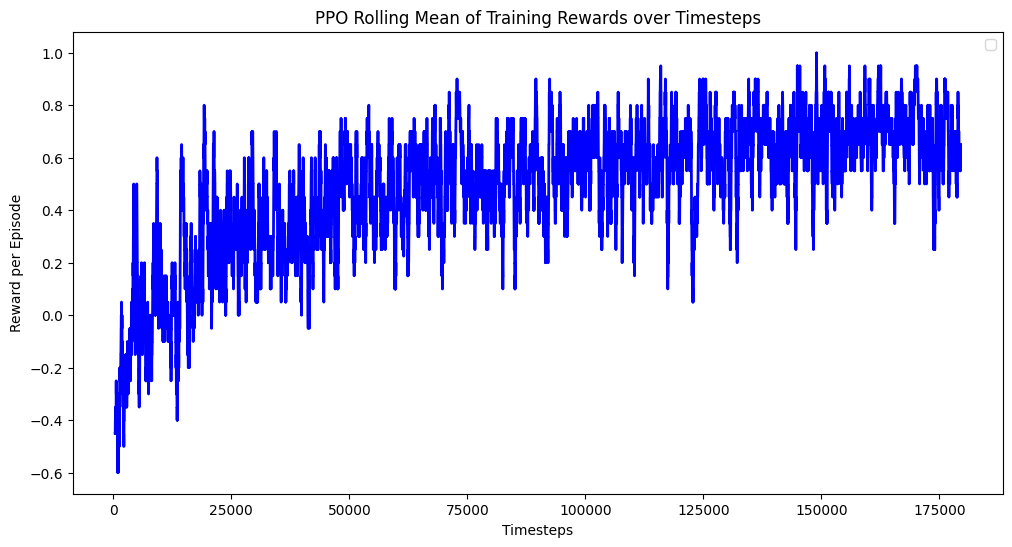

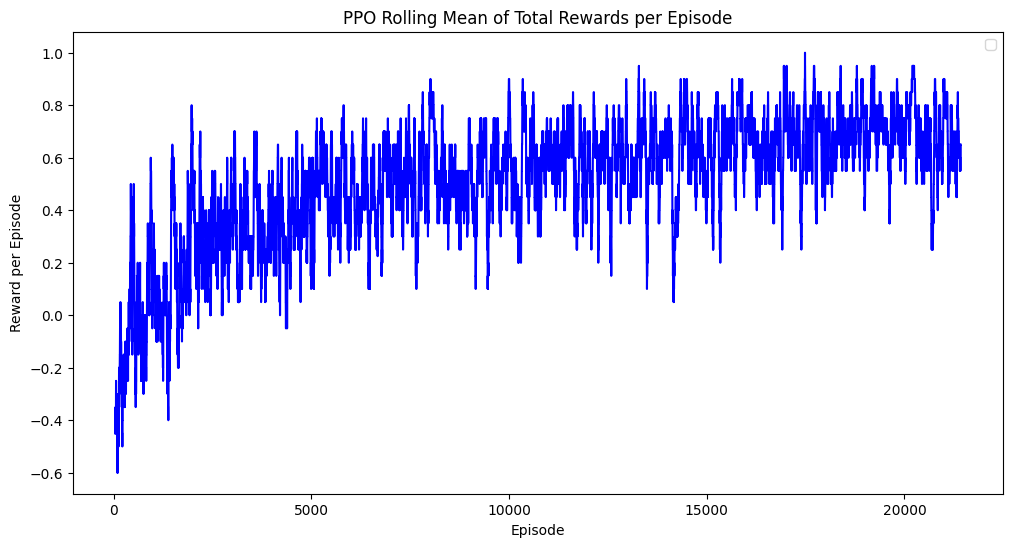

In [33]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_PPO)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})


# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards'] = results_df['rewards'].rolling(window=40).mean()

# Plot only the rolling mean for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards'], color='blue', linewidth=2)
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('PPO Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_PPO)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r'] = results['r'].rolling(window=40).mean()

# Plot rewards over episode index with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r'], color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('PPO Rolling Mean of Total Rewards per Episode')
plt.show()

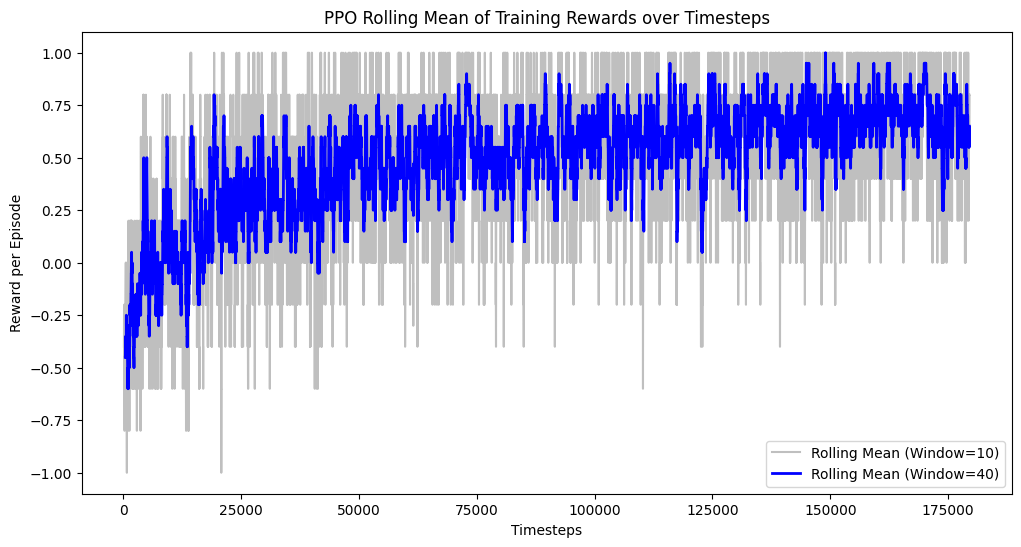

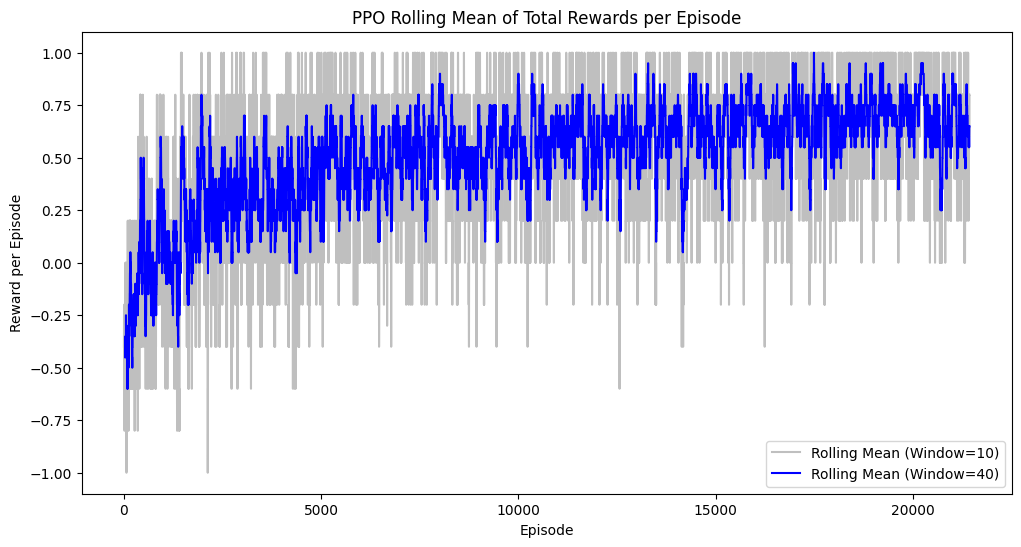

In [91]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_PPO)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

# Apply rolling mean with a window size of 40 for training rewards
results_df['rolling_mean_rewards_40'] = results_df['rewards'].rolling(window=40).mean()

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards_10'] = results_df['rewards'].rolling(window=10).mean()

# Plot both the rolling mean with window 40 and 10 for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards_10'], color='grey', alpha=0.5, label='Rolling Mean (Window=10)')
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards_40'], color='blue', linewidth=2, label='Rolling Mean (Window=40)')
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('PPO Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_PPO)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 40 for episode rewards
results['rolling_mean_r_40'] = results['r'].rolling(window=40).mean()

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r_10'] = results['r'].rolling(window=10).mean()

# Plot rewards over episode index with both rolling means
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r_10'], color='grey', alpha=0.5, label='Rolling Mean (Window=10)')
plt.plot(results.index, results['rolling_mean_r_40'], color='blue', label='Rolling Mean (Window=40)')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('PPO Rolling Mean of Total Rewards per Episode')
plt.show()


       timesteps  rewards
0              9      1.0
1             16      1.0
2             23      1.0
3             30      1.0
4             43     -1.0
...          ...      ...
26614     172378      1.0
26615     172382      1.0
26616     172387      1.0
26617     172391      1.0
26618     172397      1.0

[26619 rows x 2 columns]


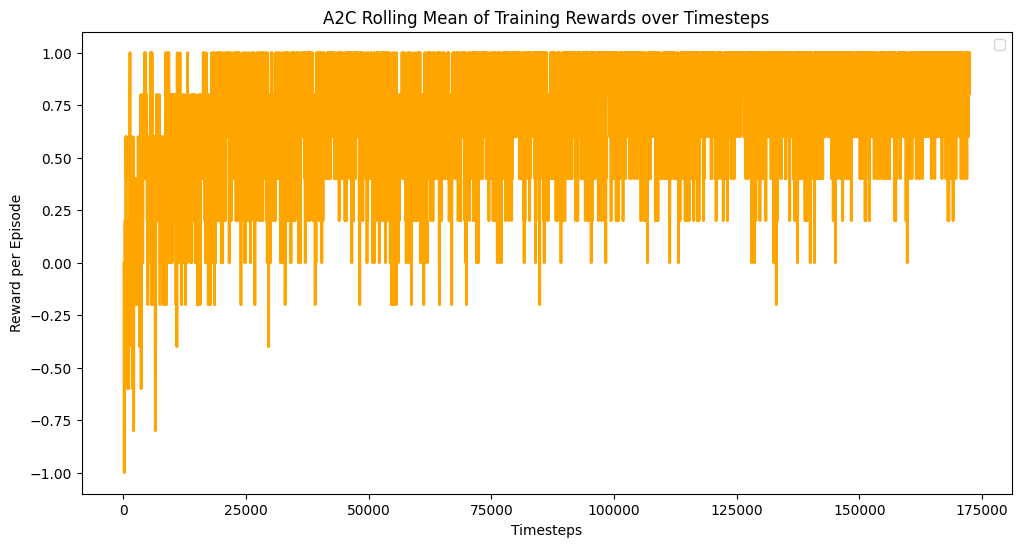

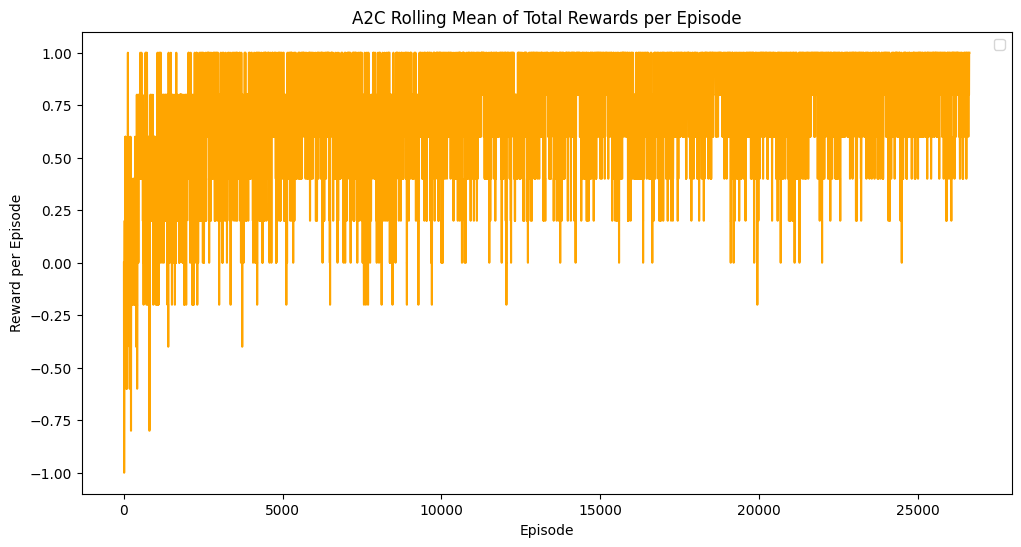

In [34]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_A2C)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

print(results_df)

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards'] = results_df['rewards'].rolling(window=10).mean()

# Plot only the rolling mean for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards'], color='orange', linewidth=2)
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('A2C Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_A2C)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r'] = results['r'].rolling(window=10).mean()

# Plot rewards over episode index with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r'], color='orange')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('A2C Rolling Mean of Total Rewards per Episode')
plt.show()

       timesteps  rewards
0              9      1.0
1             16      1.0
2             23      1.0
3             30      1.0
4             43     -1.0
...          ...      ...
26614     172378      1.0
26615     172382      1.0
26616     172387      1.0
26617     172391      1.0
26618     172397      1.0

[26619 rows x 2 columns]


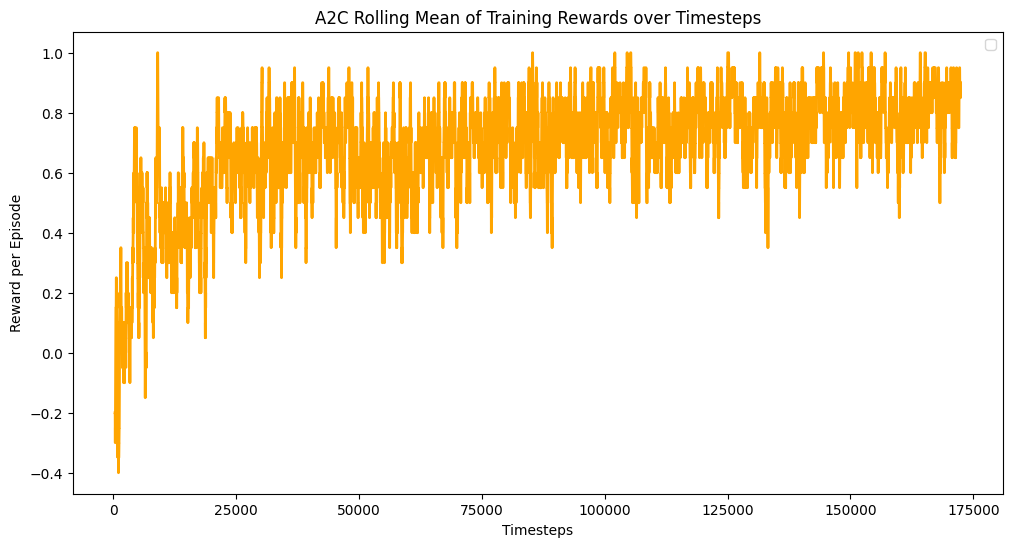

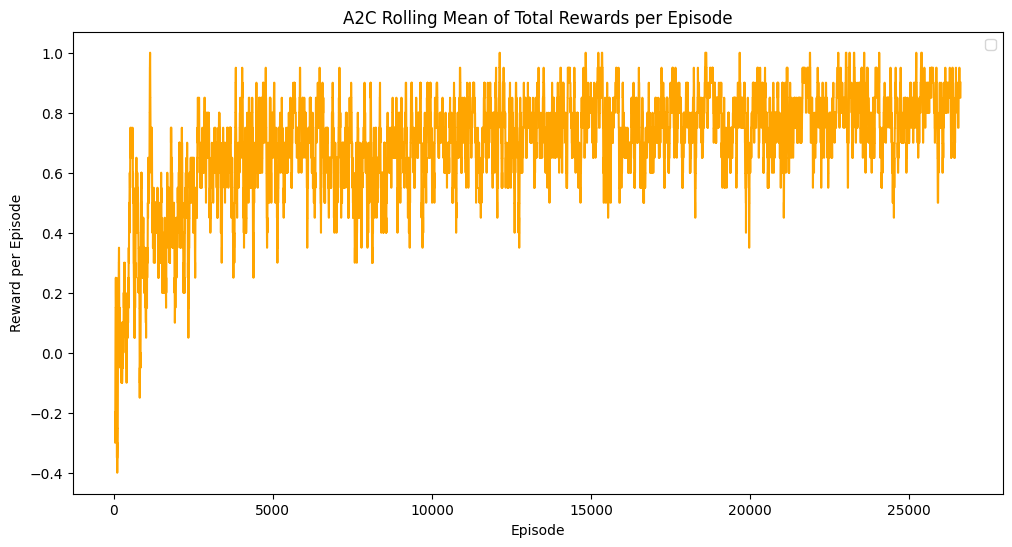

In [35]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_A2C)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

print(results_df)

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards'] = results_df['rewards'].rolling(window=40).mean()

# Plot only the rolling mean for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards'], color='orange', linewidth=2)
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('A2C Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_A2C)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r'] = results['r'].rolling(window=40).mean()

# Plot rewards over episode index with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r'], color='orange')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('A2C Rolling Mean of Total Rewards per Episode')
plt.show()

       timesteps  rewards
0              9      1.0
1             16      1.0
2             23      1.0
3             30      1.0
4             43     -1.0
...          ...      ...
26614     172378      1.0
26615     172382      1.0
26616     172387      1.0
26617     172391      1.0
26618     172397      1.0

[26619 rows x 2 columns]


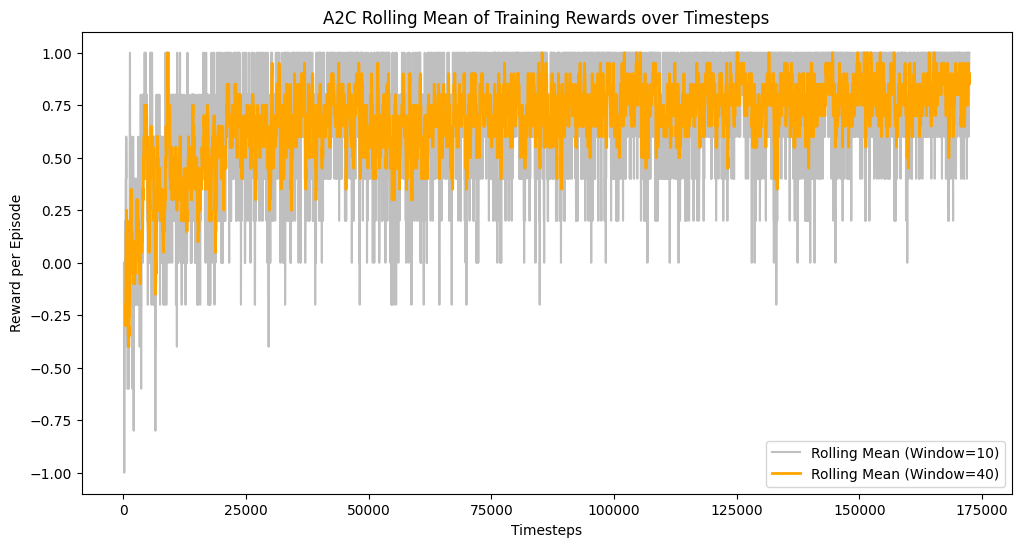

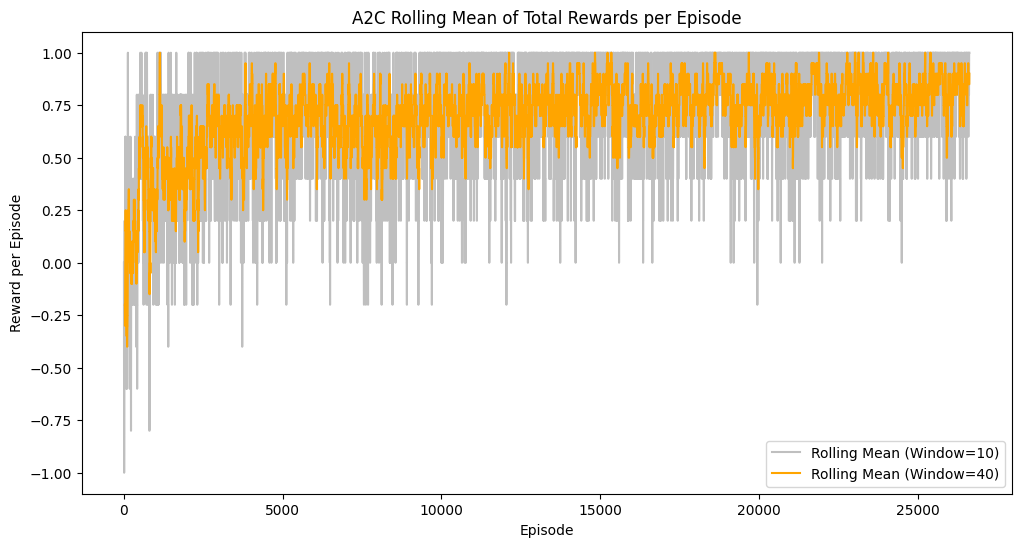

In [92]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_A2C)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

print(results_df)

# Apply rolling mean with a window size of 40 for training rewards
results_df['rolling_mean_rewards_40'] = results_df['rewards'].rolling(window=40).mean()

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards_10'] = results_df['rewards'].rolling(window=10).mean()

# Plot both the rolling mean with window 40 and 10 for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards_10'], color='grey', alpha=0.5, label='Rolling Mean (Window=10)')
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards_40'], color='orange', linewidth=2, label='Rolling Mean (Window=40)')
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('A2C Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_A2C)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 40 for episode rewards
results['rolling_mean_r_40'] = results['r'].rolling(window=40).mean()

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r_10'] = results['r'].rolling(window=10).mean()

# Plot rewards over episode index with both rolling means
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r_10'], color='grey', alpha=0.5, label='Rolling Mean (Window=10)')
plt.plot(results.index, results['rolling_mean_r_40'], color='orange', label='Rolling Mean (Window=40)')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('A2C Rolling Mean of Total Rewards per Episode')
plt.show()


       timesteps  rewards
0              8     -1.0
1             16     -1.0
2             28     -1.0
3             37     -1.0
4             51      1.0
...          ...      ...
23987     176139      1.0
23988     176152      1.0
23989     176160     -1.0
23990     176164      1.0
23991     176169      1.0

[23992 rows x 2 columns]


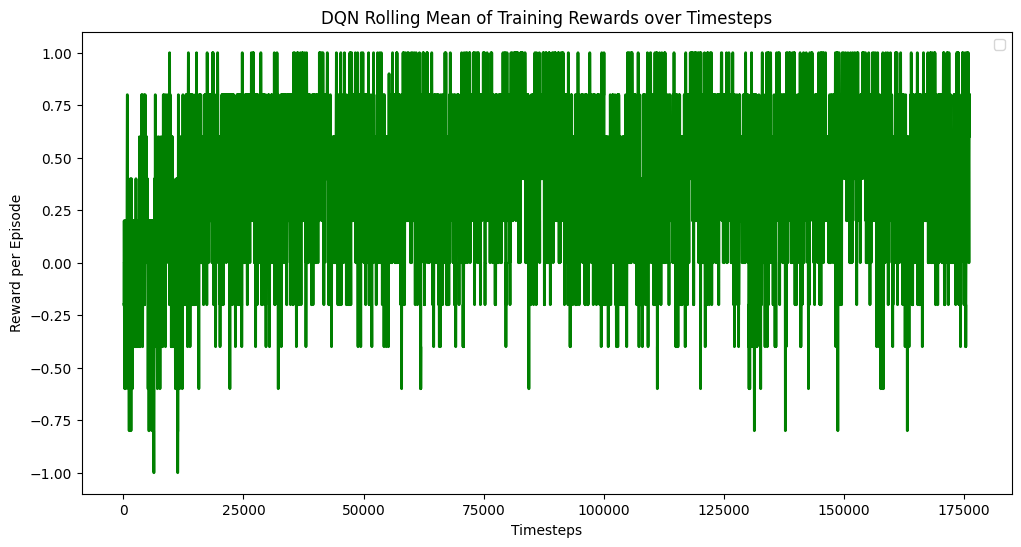

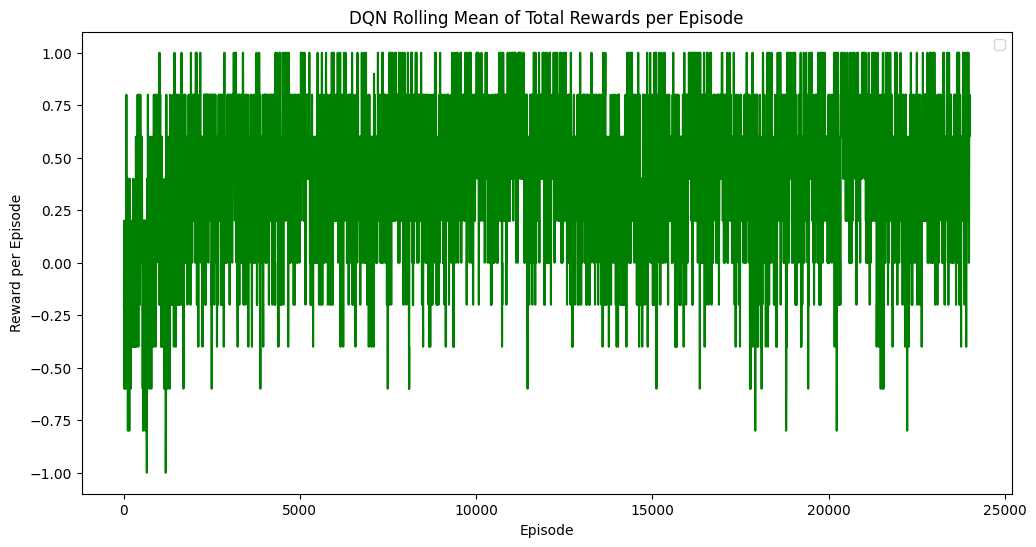

In [36]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_DQN)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

print(results_df)

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards'] = results_df['rewards'].rolling(window=10).mean()

# Plot only the rolling mean for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards'], color='green', linewidth=2)
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('DQN Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_DQN)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r'] = results['r'].rolling(window=10).mean()

# Plot rewards over episode index with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r'], color='green')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('DQN Rolling Mean of Total Rewards per Episode')
plt.show()

       timesteps  rewards
0              8     -1.0
1             16     -1.0
2             28     -1.0
3             37     -1.0
4             51      1.0
...          ...      ...
23987     176139      1.0
23988     176152      1.0
23989     176160     -1.0
23990     176164      1.0
23991     176169      1.0

[23992 rows x 2 columns]


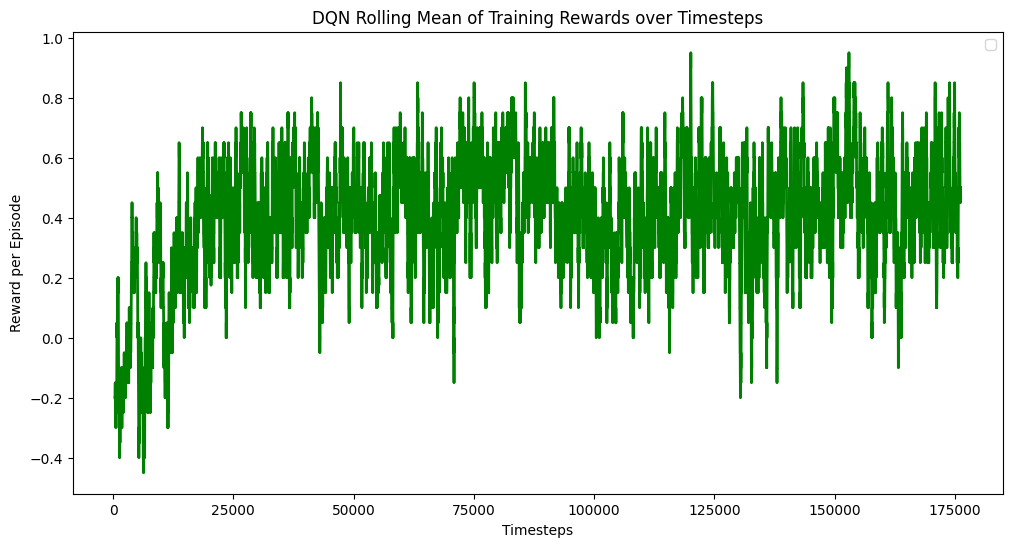

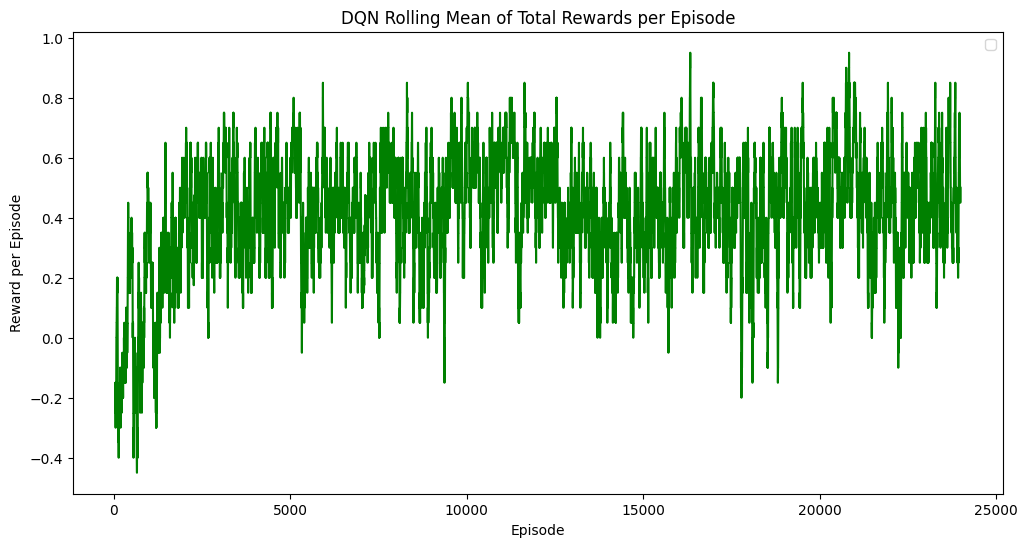

In [37]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_DQN)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

print(results_df)

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards'] = results_df['rewards'].rolling(window=40).mean()

# Plot only the rolling mean for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards'], color='green', linewidth=2)
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('DQN Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_DQN)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r'] = results['r'].rolling(window=40).mean()

# Plot rewards over episode index with rolling mean
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r'], color='green')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('DQN Rolling Mean of Total Rewards per Episode')
plt.show()

       timesteps  rewards
0              8     -1.0
1             16     -1.0
2             28     -1.0
3             37     -1.0
4             51      1.0
...          ...      ...
23987     176139      1.0
23988     176152      1.0
23989     176160     -1.0
23990     176164      1.0
23991     176169      1.0

[23992 rows x 2 columns]


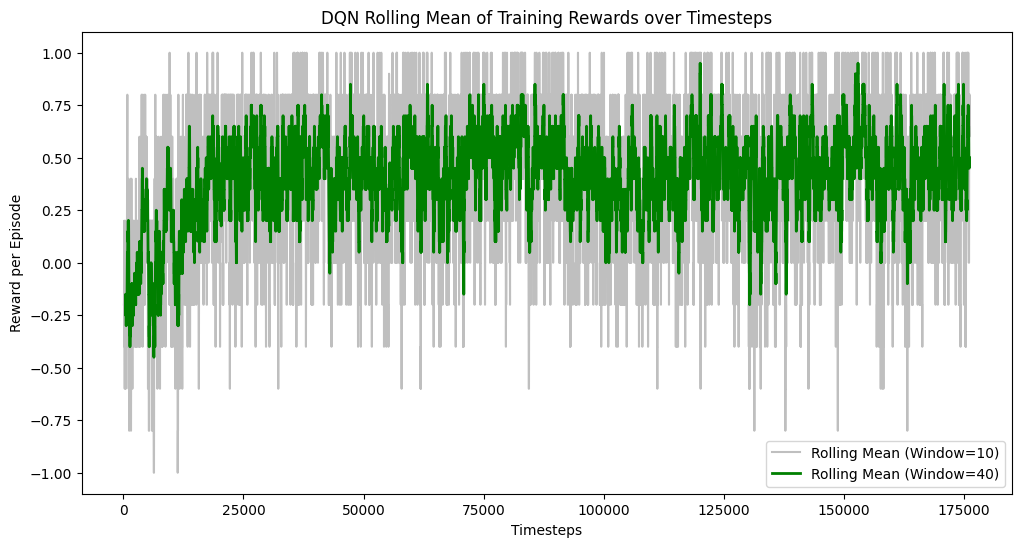

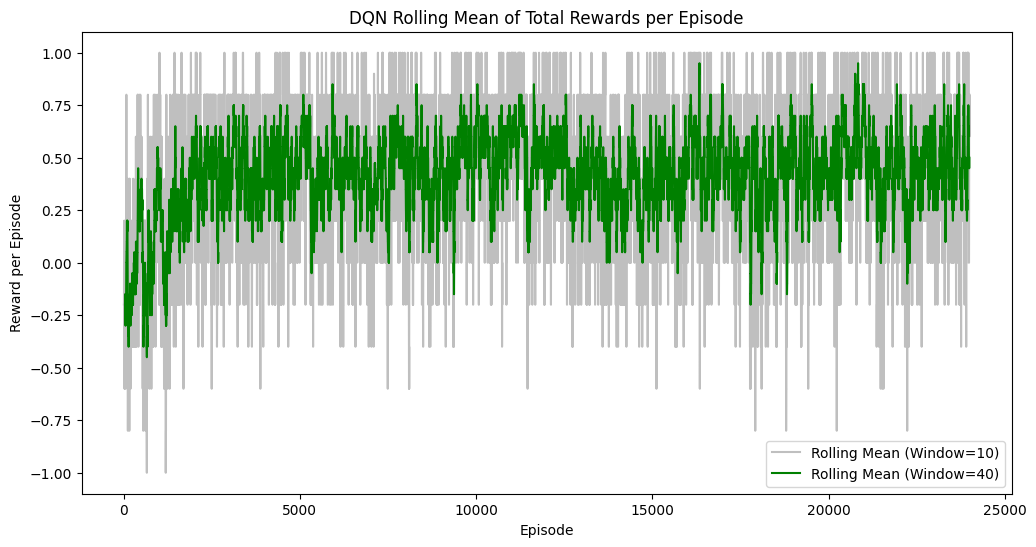

In [93]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
    rewards = np.where(rewards == -10, -1, rewards)
    # Filter based on reward >= -1
    valid_indices = rewards >= -1
    episode_lengths = episode_lengths[valid_indices]
    # Assign episodes with length < 7 to 7
    episode_lengths = np.where(episode_lengths < 7, 7, episode_lengths)
    return episode_lengths

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_DQN)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

print(results_df)

# Apply rolling mean with a window size of 40 for training rewards
results_df['rolling_mean_rewards_40'] = results_df['rewards'].rolling(window=40).mean()

# Apply rolling mean with a window size of 10 for training rewards
results_df['rolling_mean_rewards_10'] = results_df['rewards'].rolling(window=10).mean()

# Plot both the rolling mean with window 40 and 10 for training rewards
plt.figure(figsize=(12, 6))
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards_10'], color='grey', alpha=0.5, label='Rolling Mean (Window=10)')
plt.plot(results_df['timesteps'], results_df['rolling_mean_rewards_40'], color='green', linewidth=2, label='Rolling Mean (Window=40)')
plt.xlabel('Timesteps')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('DQN Rolling Mean of Training Rewards over Timesteps')
plt.show()

# Load the results from the log directory for episodes
results = load_results(LOG_DIR_DQN)
# Replace reward of -10 with -1 using loc to avoid SettingWithCopyWarning
results.loc[results['r'] == -10, 'r'] = -1
# Filter based on reward >= -1
results = results[results['r'] >= -1]

# Apply rolling mean with a window size of 40 for episode rewards
results['rolling_mean_r_40'] = results['r'].rolling(window=40).mean()

# Apply rolling mean with a window size of 10 for episode rewards
results['rolling_mean_r_10'] = results['r'].rolling(window=10).mean()

# Plot rewards over episode index with both rolling means
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['rolling_mean_r_10'], color='grey', alpha=0.5, label='Rolling Mean (Window=10)')
plt.plot(results.index, results['rolling_mean_r_40'], color='green', label='Rolling Mean (Window=40)')
plt.xlabel('Episode')
plt.ylabel('Reward per Episode')
plt.legend()
plt.title('DQN Rolling Mean of Total Rewards per Episode')
plt.show()


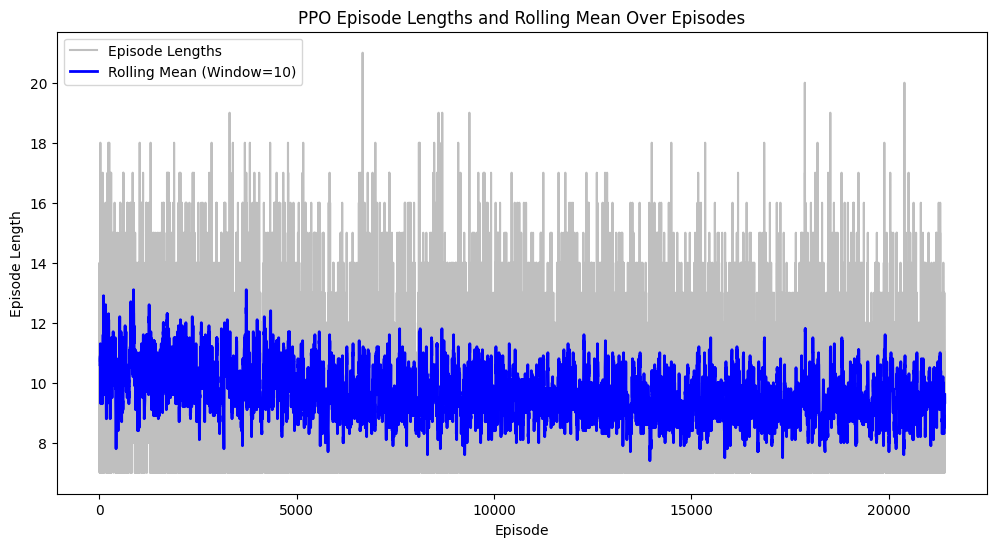

In [38]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Filter based on episode length and reward
    valid_indices = (episode_lengths >= 7) & (rewards >= -1)
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Filter based on episode length and reward
    valid_indices = (episode_lengths >= 7) & (rewards >= -1)
    return episode_lengths[valid_indices]

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_PPO)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

# Load filtered episode lengths for PPO
episode_lengths_ppo = load_filtered_episode_lengths(LOG_DIR_PPO)

# Create a DataFrame to apply the rolling mean to episode lengths
episode_lengths_df = pd.DataFrame({
    'episode_lengths': episode_lengths_ppo
})

# Apply rolling mean with a window size of 10 for episode lengths
episode_lengths_df['rolling_mean_lengths'] = episode_lengths_df['episode_lengths'].rolling(window=10).mean()

# Plot episode lengths and their rolling mean over episode index
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths_df['episode_lengths'], color='grey', alpha=0.5, label='Episode Lengths')
plt.plot(episode_lengths_df['rolling_mean_lengths'], color='blue', label='Rolling Mean (Window=10)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()
plt.title('PPO Episode Lengths and Rolling Mean Over Episodes')
plt.show()

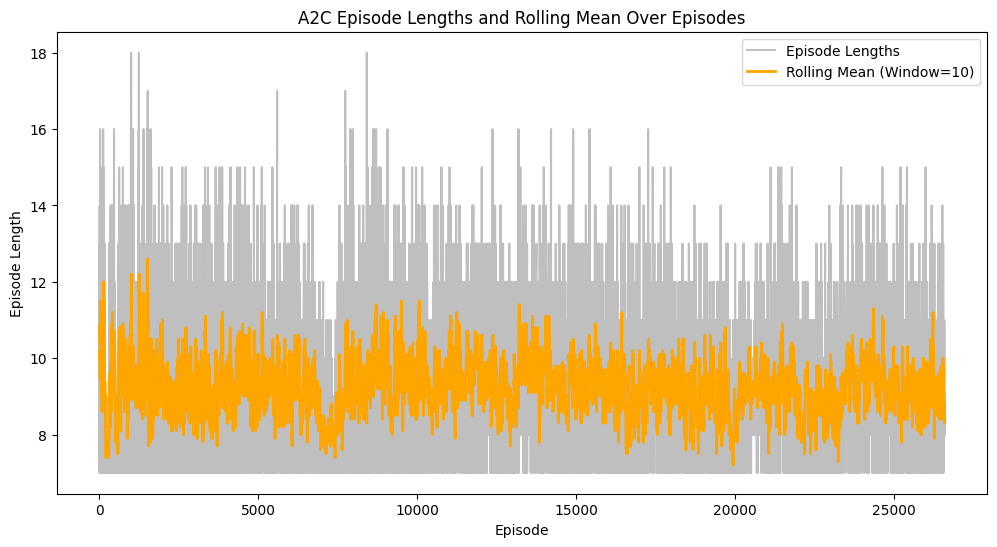

In [39]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Filter based on episode length and reward
    valid_indices = (episode_lengths >= 7) & (rewards >= -1)
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Filter based on episode length and reward
    valid_indices = (episode_lengths >= 7) & (rewards >= -1)
    return episode_lengths[valid_indices]

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_A2C)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

# Load filtered episode lengths for A2C
episode_lengths_a2c = load_filtered_episode_lengths(LOG_DIR_A2C)

# Create a DataFrame to apply the rolling mean to episode lengths
episode_lengths_df = pd.DataFrame({
    'episode_lengths': episode_lengths_a2c
})

# Apply rolling mean with a window size of 10 for episode lengths
episode_lengths_df['rolling_mean_lengths'] = episode_lengths_df['episode_lengths'].rolling(window=10).mean()

# Plot episode lengths and their rolling mean over episode index
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths_df['episode_lengths'], color='grey', alpha=0.5, label='Episode Lengths')
plt.plot(episode_lengths_df['rolling_mean_lengths'], color='orange', label='Rolling Mean (Window=10)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()
plt.title('A2C Episode Lengths and Rolling Mean Over Episodes')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


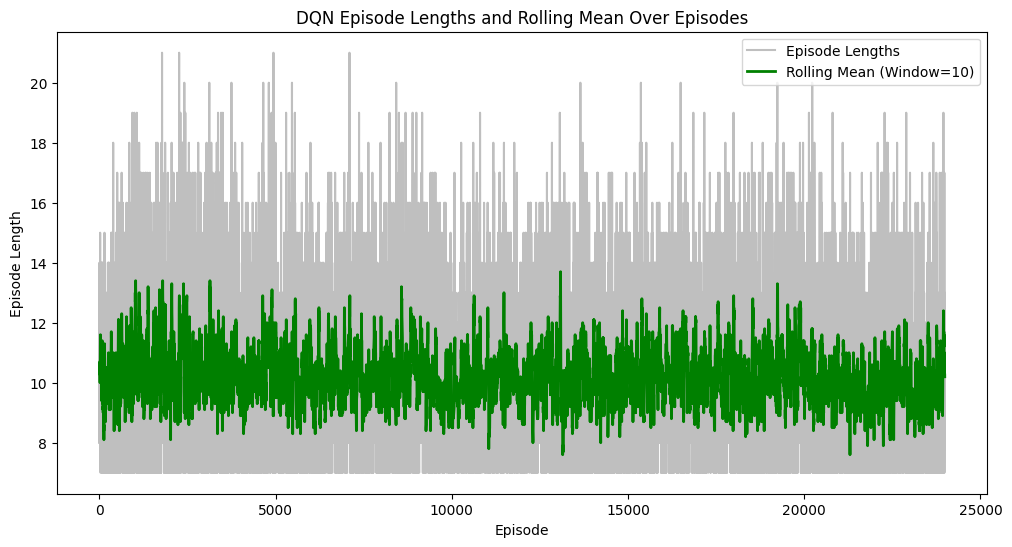

In [ ]:
from stable_baselines3.common.results_plotter import load_results, ts2xy
import pandas as pd
import matplotlib.pyplot as plt

# Function to load training results with filtering
def load_filtered_training_results(log_dir):
    results = load_results(log_dir)
    timesteps, rewards = ts2xy(results, 'timesteps')
    episode_lengths = results['l']
    # Filter based on episode length and reward
    valid_indices = (episode_lengths >= 7) & (rewards >= -1)
    return timesteps[valid_indices], rewards[valid_indices]

# Function to load episode lengths from the log directory
def load_filtered_episode_lengths(log_dir):
    results = load_results(log_dir)
    episode_lengths = results['l']
    rewards = results['r']
    # Filter based on episode length and reward
    valid_indices = (episode_lengths >= 7) & (rewards >= -1)
    return episode_lengths[valid_indices]

# Load filtered training rewards over timesteps
train_timesteps, train_rewards = load_filtered_training_results(LOG_DIR_DQN)

# Create a DataFrame to apply the rolling mean
results_df = pd.DataFrame({
    'timesteps': train_timesteps,
    'rewards': train_rewards
})

# Load filtered episode lengths for DQN
episode_lengths_dqn = load_filtered_episode_lengths(LOG_DIR_DQN)

# Create a DataFrame to apply the rolling mean to episode lengths
episode_lengths_df = pd.DataFrame({
    'episode_lengths': episode_lengths_dqn
})

# Apply rolling mean with a window size of 10 for episode lengths
episode_lengths_df['rolling_mean_lengths'] = episode_lengths_df['episode_lengths'].rolling(window=10).mean()

# Plot episode lengths and their rolling mean over episode index
plt.figure(figsize=(12, 6))
plt.plot(episode_lengths_df['episode_lengths'], color='grey', alpha=0.5, label='Episode Lengths')
plt.plot(episode_lengths_df['rolling_mean_lengths'], color='green', label='Rolling Mean (Window=10)', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.legend()
plt.title('DQN Episode Lengths and Rolling Mean Over Episodes')
plt.show()

In [ ]:
def ppo_agent(observation, config = {'rows': 6, 'columns': 7, 'inarow': 4}):
    observation = np.array(observation['board']).reshape(1, config['rows'], config['columns'])
    action, _ = agent_ppo.predict(observation)

    # Check if the action is valid
    valid_actions = [c for c in range(config['columns']) if observation[0][0][c] == 0]
    if action not in valid_actions:
        action = np.random.choice(valid_actions)

    return int(action)

def a2c_agent(observation, config={'rows': 6, 'columns': 7, 'inarow': 4}):
    observation = np.array(observation['board']).reshape(1, config['rows'], config['columns'])
    action, _ = agent_a2c.predict(observation)

    valid_actions = [c for c in range(config['columns']) if observation[0][0][c] == 0]
    if action not in valid_actions:
        action = np.random.choice(valid_actions)

    return int(action)

def dqn_agent(observation, config={'rows': 6, 'columns': 7, 'inarow': 4}):
    observation = np.array(observation['board']).reshape(1, config['rows'], config['columns'])
    action, _ = agent_dqn.predict(observation)

    valid_actions = [c for c in range(config['columns']) if observation[0][0][c] == 0]
    if action not in valid_actions:
        action = np.random.choice(valid_actions)

    return int(action)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 6, 'columns': 7, 'inarow': 4}
    # Agent 1 goes first (roughly) half the time
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    # Agent 2 goes first (roughly) half the time
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))


In [41]:
# Create the game environment
env = make("connectx", debug=True)

env.run([ppo_agent, ppo_agent])

# To render using iPython, we have to use a notebook as the Kaggle editor can't show HTML objects
env.render(mode="ipython", width=500, height=450)


get_win_percentages(agent1=ppo_agent, agent2='random')
print('\n')


Agent 1 Win Percentage: 0.86
Agent 2 Win Percentage: 0.14
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [65]:
get_win_percentages(agent1=ppo_agent, agent2='negamax')
print('\n')

Agent 1 Win Percentage: 0.07
Agent 2 Win Percentage: 0.93
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [43]:
get_win_percentages(agent1=ppo_agent, agent2=ppo_agent)

Agent 1 Win Percentage: 0.55
Agent 2 Win Percentage: 0.45
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0


In [44]:
print("Evaluating A2C Agent against Random:")
get_win_percentages(agent1=a2c_agent, agent2='random')
print('\n')


Evaluating A2C Agent against Random:
Agent 1 Win Percentage: 0.94
Agent 2 Win Percentage: 0.06
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [57]:
print("Evaluating A2C Agent against Negamax:")
get_win_percentages(agent1=a2c_agent, agent2='negamax')
print('\n')

Evaluating A2C Agent against Negamax:
Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 1.0
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [58]:
print("Evaluating A2C Agent against A2C Agent:")
get_win_percentages(agent1=a2c_agent, agent2=a2c_agent)
print('\n')

Evaluating A2C Agent against A2C Agent:
Agent 1 Win Percentage: 0.49
Agent 2 Win Percentage: 0.51
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [47]:
env.run([a2c_agent, a2c_agent])
env.render(mode="ipython", width=500, height=450)

In [48]:
print("Evaluating DQN Agent against Random:")
get_win_percentages(agent1=dqn_agent, agent2='random')
print('\n')

Evaluating DQN Agent against Random:
Agent 1 Win Percentage: 0.82
Agent 2 Win Percentage: 0.18
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [49]:
print("Evaluating DQN Agent against Negamax:")
get_win_percentages(agent1=dqn_agent, agent2='negamax')
print('\n')

Evaluating DQN Agent against Negamax:
Agent 1 Win Percentage: 0.02
Agent 2 Win Percentage: 0.98
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [51]:
env.run([dqn_agent, dqn_agent])
env.render(mode="ipython", width=500, height=450)

In [52]:
print("Evaluating DQN Agent against PPO Agent:")
get_win_percentages(agent1=dqn_agent, agent2=ppo_agent)
print('\n')

Evaluating DQN Agent against PPO Agent:
Agent 1 Win Percentage: 0.5
Agent 2 Win Percentage: 0.5
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [53]:
print("Evaluating DQN Agent against A2C Agent:")
get_win_percentages(agent1=dqn_agent, agent2=a2c_agent)
print('\n')

Evaluating DQN Agent against A2C Agent:
Agent 1 Win Percentage: 0.48
Agent 2 Win Percentage: 0.52
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [54]:
print("Evaluating PPO Agent against A2C Agent:")
get_win_percentages(agent1=ppo_agent, agent2=a2c_agent)
print('\n')

Evaluating PPO Agent against A2C Agent:
Agent 1 Win Percentage: 0.34
Agent 2 Win Percentage: 0.66
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0




In [55]:
# Create the game environment
env = make("connectx", debug=True)

env.run(['negamax', 'random'])

# To render using iPython, we have to use a notebook as the Kaggle editor can't show HTML objects
env.render(mode="ipython", width=500, height=450)


get_win_percentages(agent1='negamax', agent2='random')

Agent 1 Win Percentage: 0.98
Agent 2 Win Percentage: 0.02
Number of Invalid Plays by Agent 1: 0
Number of Invalid Plays by Agent 2: 0
